# Setup

In [1]:
# import modules

import toolbox_morph
import numpy as np 
import matplotlib.pyplot as plt
from astropy.table import Table
import glob
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import pickle


In [2]:
# define paths

path_main_directory = '/home/wolbach/Desktop/SRMP/morph_project/'
path_SFH_table = path_main_directory + 'SFH/Behroozi+19/'


# Set up model

In [3]:
# set up radial bins of the models (don't use too many otherwise everything will be slow...)

radius_kpc = np.logspace(-1.0, 1.3, num=20)
print (radius_kpc)


[ 0.1         0.13214558  0.17462454  0.2307586   0.30493728  0.40296113
  0.53249531  0.703669    0.92986747  1.22877873  1.62377674  2.14574914
  2.83551258  3.74700446  4.95150067  6.54318913  8.64653503 11.42601361
 15.09897161 19.95262315]


In [4]:
# create list of SFH tables

# list_SFH_tables = glob.glob(path_SFH_table + '*a1.002310.dat')

# just use mass range of logM = 9-12 at z=0
list_SFH_tables = np.append(np.append(glob.glob(path_SFH_table + '*sm9*a1.002310.dat'), glob.glob(path_SFH_table + '*sm10*a1.002310.dat')), glob.glob(path_SFH_table + '*sm11*a1.002310.dat'))

print(list_SFH_tables)
print(len(list_SFH_tables))


['/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.70_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.10_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.50_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.30_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm9.90_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.50_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.70_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.30_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.90_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm10.10_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/sfh_sm11.50_a1.002310.dat'
 '/home/wolbach/Desktop/SRMP/morph_project/SFH/Behroozi+19/

# Observations

## Size-mass relation for star-forming and quiescent galaxies 

In [5]:
# define size-mass relation from observations; these are the observations we want to fit

# Moein+13 for z=0

def Mosleh2013_SF(mass):
    alpha, beta, gamma, M0 = 0.109, 0.263, 10**-0.743, 10**10.204
    return(gamma*mass**alpha*(1+mass/M0)**(beta-alpha))

def Mosleh2013_Q(mass):
    alpha, beta, gamma, M0 = 0.014, 0.912, 10**-0.058, 10**10.555
    return(gamma*mass**alpha*(1+mass/M0)**(beta-alpha))



In [6]:
# Mowla+19 for z>0

Mowla_table = np.array([0.25, 0.74, 0.27, 0.83, 0.29, 0.59, 0.47])
Mowla_table = np.vstack([Mowla_table, np.array([0.75, 0.65, 0.17, 0.74, 0.21, 0.44, 0.57])])
Mowla_table = np.vstack([Mowla_table, np.array([1.25, 0.60, 0.13, 0.67, 0.19, 0.26, 0.65])])
Mowla_table = np.vstack([Mowla_table, np.array([1.75, 0.53, 0.09, 0.61, 0.18, 0.17, 0.63])])
Mowla_table = np.vstack([Mowla_table, np.array([2.25, 0.49, 0.13, 0.53, 0.18, 0.06, 0.48])])
Mowla_table = np.vstack([Mowla_table, np.array([2.75, 0.48, 0.11, 0.51, 0.14, 0.12, 0.59])])

Mowla_table = Table(Mowla_table, names=('redshift', 'logA_all', 'alpha_all', 'logA_SF', 'alpha_SF', 'logA_Q', 'alpha_Q'))


In [7]:

def get_size_observations(redshift_in, mass_in, SF_in):
    '''
    Combination of Mosleh+ and Mowla+.
    '''
    if (redshift_in == 0.0):
        if SF_in:
            logR = np.log10(Mosleh2013_SF(10**mass_in))
        else:
            logR = np.log10(Mosleh2013_Q(10**mass_in))
    else:
        if SF_in:
            logA = np.interp(redshift_in, Mowla_table['redshift'], Mowla_table['logA_SF'])
            alpha = np.interp(redshift_in, Mowla_table['redshift'], Mowla_table['alpha_SF'])
        else:
            logA = np.interp(redshift_in, Mowla_table['redshift'], Mowla_table['logA_Q'])
            alpha = np.interp(redshift_in, Mowla_table['redshift'], Mowla_table['alpha_Q'])
        logR = np.log10(10**logA*(10.**mass_in/(5.0*10**10))**alpha)
    return(logR)


## Size-mass relation for all galaxies 

In [8]:
# define size-mass relation from observations; these are the observations we want to fit

Mowla2_table = np.array([0.37, 8.6, 10.2, 0.17, 0.50, 3.8, 10.3, 0.09, 0.37])
Mowla2_table = np.vstack([Mowla2_table, np.array([0.79, 8.7, 10.5, 0.17, 0.61, 4.0, 10.7, 0.10, 0.45])])
Mowla2_table = np.vstack([Mowla2_table, np.array([1.24, 8.3, 10.8, 0.16, 0.69, 4.2, 11.1, 0.13, 0.53])])
Mowla2_table = np.vstack([Mowla2_table, np.array([1.72, 7.6, 10.9, 0.15, 0.62, 3.7, 11.1, 0.11, 0.50])])
Mowla2_table = np.vstack([Mowla2_table, np.array([2.24, 6.5, 11.0, 0.14, 0.53, 3.1, 11.0, 0.11, 0.42])])
Mowla2_table = np.vstack([Mowla2_table, np.array([2.69, 5.3, 10.8, 0.05, 0.34, 2.8, 10.9, 0.06, 0.38])])

Mowla2_table = Table(Mowla2_table, names=('redshift', 'rp_r80', 'logMp_r80', 'alpha_r80', 'beta_r80', 'rp_r50', 'logMp_r50', 'alpha_r50', 'beta_r50'))

def get_size_observations_all(redshift_in, mass_in, type_in):
    if (type_in=='r80'):
        rp = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['rp_r80'])
        logMp = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['logMp_r80'])
        alpha = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['alpha_r80'])
        beta = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['beta_r80'])
    elif (type_in=='r50'):
        rp = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['rp_r50'])
        logMp = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['logMp_r50'])
        alpha = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['alpha_r50'])
        beta = np.interp(redshift_in, Mowla2_table['redshift'], Mowla2_table['beta_r50'])
    delta = 6.0
    return(np.log10(rp*(10**mass_in/10**logMp)**alpha*(0.5*(1+(10**mass_in/10**logMp)**delta))**((beta-alpha)/delta)))



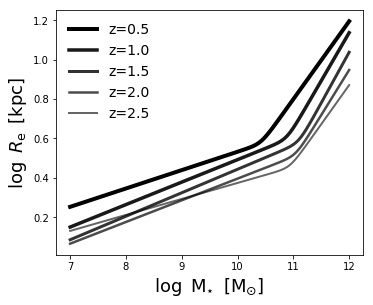

In [9]:
# plot size-mass relation

log_mass_plot = np.linspace(7.0, 12.0, num=100)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 4.5))

# plot observations
#ax.plot(log_mass_plot, get_size_observations(0.0, log_mass_plot, True), '-', lw=3, color='C0', label='SF: z=0')
#ax.plot(log_mass_plot, get_size_observations(0.25, log_mass_plot, True), '--', lw=3, color='C0', label='SF: z=0.25')
#ax.plot(log_mass_plot, get_size_observations(1.0, log_mass_plot, True), '--', lw=3, color='C0', label='SF: z=1')
#ax.plot(log_mass_plot, get_size_observations(2.0, log_mass_plot, True), ':', lw=3, color='C0', label='SF: z=2')
#ax.plot(log_mass_plot, get_size_observations(0.0, log_mass_plot, False), '-', lw=3, color='C3', label='Q: z=0')
#ax.plot(log_mass_plot, get_size_observations(0.25, log_mass_plot, False), '--', lw=3, color='C3', label='Q: z=0.25')
#ax.plot(log_mass_plot, get_size_observations(1.0, log_mass_plot, False), '--', lw=3, color='C3', label='Q: z=1')
#ax.plot(log_mass_plot, get_size_observations(2.0, log_mass_plot, False), ':', lw=3, color='C3', label='Q: z=2')

ax.plot(log_mass_plot, get_size_observations_all(0.5, log_mass_plot, 'r50'), '-', lw=4.0, alpha=1.0, color='black', label='z=0.5')
ax.plot(log_mass_plot, get_size_observations_all(1.0, log_mass_plot, 'r50'), '-', lw=3.5, alpha=0.9, color='black', label='z=1.0')
ax.plot(log_mass_plot, get_size_observations_all(1.5, log_mass_plot, 'r50'), '-', lw=3.0, alpha=0.8, color='black', label='z=1.5')
ax.plot(log_mass_plot, get_size_observations_all(2.0, log_mass_plot, 'r50'), '-', lw=2.5, alpha=0.7, color='black', label='z=2.0')
ax.plot(log_mass_plot, get_size_observations_all(2.5, log_mass_plot, 'r50'), '-', lw=2.0, alpha=0.6, color='black', label='z=2.5')



# set axes
ax.set_xlabel(r'$\log\/\/\/\mathrm{M_{\star}}\/\/\/[\mathrm{M_{\odot}}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/R_{\rm e}\/\/\/[\mathrm{kpc}]$', fontsize=18)

#ax.set_xlim([9.0, 11.5])
#ax.set_ylim([-0.3, 1.5])

ax.legend(frameon=False, fontsize=14, loc='upper left')

plt.show()


In [68]:
# read in table
observations_3DHST = Table.read(path_main_directory + 'data/3DHST_combined_catalog.dat', format='ascii')

In [69]:
observations_3DHST

id,field,ra,dec,flag_use_phot,redshift,redshift_type,redshift_spec,redshift_phot,lmass,lsfr_best,lsfr_SED,lsfr_UVIR,lsfr_UV,lsfr_IR,mag_V,mag_I,mag_J,mag_H,col_UV,col_VJ,re,n,morph_flag,Ha_flux,Hb_flux,OIII_flux,SII_flux,HaEQW_flux,HaEQW_err
float64,str7,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
1.0,AEGIS,215.22238159,53.00418472,0,0.01,2,-1.0,0.01,7.51,-1.4005973180704152,-0.16,-1.4005973180704152,-1.4039750104769186,-3.511280110810835,16.86750354960777,16.380206543882608,14.002417364732755,13.914056846874441,0.4316625787877739,2.452126648614677,0.018,1.1623,2,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2.0,AEGIS,215.09658813,52.91805267,0,0.01,2,-1.0,0.01,5.62,-12.18,-12.18,nan,-4.458146288818353,nan,20.10325590324836,19.588746096726076,18.994604571243155,18.82430461598312,1.3348747650793023,2.9959186322376903,2.93326,0.4248,0,-99.0,34.18,31.51,-99.0,-99.0,-99.0
3.0,AEGIS,215.16146851,52.95946121,1,0.2062,2,-1.0,0.2062,9.0,0.1584831126992477,-0.19,0.1584831126992477,-0.6604094477319599,0.08703566480566013,21.447101163064797,21.051084012322633,20.449085787391894,20.359658646467135,1.0696648285511765,0.8628446821123654,-999.0,-999.0,3,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
4.0,AEGIS,215.30529785,53.0529213,0,0.0355,2,-1.0,0.0355,4.78,-2.88,-2.88,nan,-3.3676540796537893,nan,25.88058930611057,25.84353035723874,24.873760602790362,24.867399978393134,0.15188545577033719,0.7315598530681632,0.059172,8.0,2,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
5.0,AEGIS,215.0418396,52.87127304,0,0.3427,2,-1.0,0.3427,11.57,0.26808630444738396,0.1,0.26808630444738396,0.23003998115794236,-0.8082137524178007,19.183648328708596,17.878342015093708,nan,nan,2.157925079843398,1.5200405249274658,-999.0,-999.0,3,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
6.0,AEGIS,215.30380249,53.05212021,0,0.7217,2,-1.0,0.7217,8.51,-0.39,-0.39,nan,-0.09081852402214716,nan,24.34660488451469,23.953294062610667,23.88653444241959,23.918819469781695,0.3782618974021618,0.25957964097055997,0.2655,0.8969,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
7.0,AEGIS,215.26712036,53.02758408,0,0.0424,2,-1.0,0.0424,6.26,-2.4378499407671184,-12.96,-2.4378499407671184,-5.638140007510706,-2.438123782100983,26.525313604022536,25.92731739143268,25.438123859901744,25.55527351127447,2.51055141920478,1.1387906784842032,0.018,8.0,2,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8.0,AEGIS,215.3032074,53.05295563,1,0.8557,2,-1.0,0.8557,8.08,-0.95,-0.95,nan,-0.8533759111759944,nan,26.68929386175577,26.1818599631111,25.60594063522903,25.602663524693245,0.5885593182469963,0.18074537332409468,0.175416,1.0807,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
9.0,AEGIS,215.30378723,53.05344391,1,0.1806,2,-1.0,0.1806,6.95,-16.91,-16.91,nan,-3.6359746031495517,nan,26.608979182402546,26.2975765581151,25.902105860793082,25.629374838390277,1.7129902553018401,0.9084791330637715,0.178686,0.5295,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


/home/wolbach/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


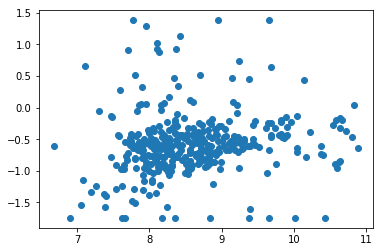

In [137]:
# attempts to plot Re vs M from observations_3DHST for z~1
re_list = []
lmass_list = []

for data_ii in np.arange(2001):
    if observations_3DHST['redshift'][data_ii] < 1.25 and observations_3DHST['redshift'][data_ii] > 0.75:
        re_list.append(observations_3DHST['re'][data_ii])
        lmass_list.append(observations_3DHST['lmass'][data_ii])
        

x = lmass_list
y = np.log10(re_list)
plt.plot(x, y, 'o')
plt.show()
    

In [117]:
observations_3DHST['redshift']

0.01
0.01
0.2062
0.0355
0.3427
0.7217
0.0424
0.8557
0.1806
3.3584
0.972


In [99]:
observations_3DHST['redshift'][3]

0.0355

# Sample space

In [10]:
# define functions

def sigmoid(x, a, b, c):
    return(b/(1.0+np.exp(-a*(x-c))))

def exp_fct(x, a, b):
    f = 1.0+np.exp(a*(x-b))
    return(f)

def get_properties(redshift_in, alpha, beta, gamma, delta, epsilon):
    '''
    This function returns masses and sizes for a given redshift and parameters.
    '''
    redshift_list = []
    mass_list = []
    RM_list = []
    for SFH_file in list_SFH_tables:
        # read in table
        SFH_table = Table.read(SFH_file, format='ascii', names=('scale_factor', 'SFH_all', 'SFH_all_up', 'SFH_all_dw', 'SFH_SF', 'SFH_SF_up', 'SFH_SF_dw', 'SFH_Q', 'SFH_Q_up', 'SFH_Q_dw', 'SFH_Cen', 'SFH_Cen_up', 'SFH_Cen_dw', 'SFH_Sat', 'SFH_Sat_up', 'SFH_Sat_dw', 'scale_factor_begin', 'scale_factor_end')) 
        # set up galaxies and get props
        gal = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_all'], [alpha, beta, gamma])
        for ii_z in redshift_in:
            RM = gal.get_size(redshift_in=ii_z)
            mass = gal.get_mass_after_mass_loss(redshift_in=ii_z)
            # merging
            # merger_eff = sigmoid(np.log10(mass), delta, epsilon, 11.2)
            merger_eff = exp_fct(np.log10(mass), delta, epsilon)
            mass = merger_eff*mass
            RM = merger_eff*RM
            # append
            redshift_list.append(ii_z)
            mass_list.append(mass)
            RM_list.append(RM)
    # convert lists to arrays
    redshift_list = np.array(redshift_list)
    mass_list = np.array(mass_list)
    RM_list = np.array(RM_list)
    return(redshift_list, mass_list, RM_list)


In [11]:
# define functions: for star-forming and quiescent galaxies

def get_properties_SFQ(redshift_in, alpha, beta, gamma, delta):
    '''
    This function returns masses and sizes for a given redshift and parameters.
    '''
    redshift_list = []
    mass_Q_list = []
    mass_SF_list = []
    RM_Q_list = []
    RM_SF_list = []
    #S1_Q_list = []
    #S1_SF_list = []
    for SFH_file in list_SFH_tables:
        # read in table
        SFH_table = Table.read(SFH_file, format='ascii', names=('scale_factor', 'SFH_all', 'SFH_all_up', 'SFH_all_dw', 'SFH_SF', 'SFH_SF_up', 'SFH_SF_dw', 'SFH_Q', 'SFH_Q_up', 'SFH_Q_dw', 'SFH_Cen', 'SFH_Cen_up', 'SFH_Cen_dw', 'SFH_Sat', 'SFH_Sat_up', 'SFH_Sat_dw', 'scale_factor_begin', 'scale_factor_end')) 
        # set up galaxies (SF and Q) and get props
        gal_Q = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_Q'], [alpha, beta, gamma, delta])
        gal_SF = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_SF'], [alpha, beta, gamma, delta])
        for ii_z in redshift_in:
            RM_Q = gal_Q.get_size(redshift_in=ii_z)
            RM_SF = gal_SF.get_size(redshift_in=ii_z)
            #S1_Q = gal_Q.get_mass_within_R(Rmax=1.0, redshift_in=redshift_in)/np.pi
            #S1_SF = gal_SF.get_mass_within_R(Rmax=1.0, redshift_in=redshift_in)/np.pi
            mass_Q = gal_Q.get_mass_after_mass_loss(redshift_in=ii_z)
            mass_SF = gal_SF.get_mass_after_mass_loss(redshift_in=ii_z)
            # append
            redshift_list.append(ii_z)
            mass_Q_list.append(mass_Q)
            mass_SF_list.append(mass_SF)
            RM_Q_list.append(RM_Q)
            RM_SF_list.append(RM_SF)
            #S1_Q_list.append(S1_Q)
            #S1_SF_list.append(S1_SF)
    # convert lists to arrays
    redshift_list = np.array(redshift_list)
    mass_Q_list = np.array(mass_Q_list)
    mass_SF_list = np.array(mass_SF_list)
    RM_Q_list = np.array(RM_Q_list)
    RM_SF_list = np.array(RM_SF_list)
    #S1_Q_list = np.array(S1_Q_list)
    #S1_SF_list = np.array(S1_SF_list)
    # sort
    #sort_index = redshift_list.argsort()
    return(redshift_list, mass_Q_list, mass_SF_list, RM_Q_list, RM_SF_list)


In [12]:
# testing

get_properties([0.5, 1.0, 2.0], 1, 1, 1, 1, 1)


/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:98: RuntimeWarning: divide by zero encountered in true_divide
  self.time_boundary = cosmo.age(1.0/self.scale_factor_boundary-1.0).value
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:99: RuntimeWarning: divide by zero encountered in true_divide
  self.time_dt = np.diff(cosmo.age(1.0/self.scale_factor_boundary-1.0).value)


(array([0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5,
        1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. ,
        2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. , 0.5, 1. , 2. ,
        0.5, 1. , 2. ]),
 array([1.37766747e+13, 3.41188229e+12, 5.21152120e+11, 1.39743428e+12,
        4.35025994e+11, 8.41345097e+10, 6.18368993e+12, 1.62542722e+12,
        2.74795598e+11, 2.87635172e+12, 8.21653692e+11, 1.48733407e+11,
        3.19141040e+13, 8.01405353e+12, 1.10367218e+12, 3.63757857e+14,
        1.56752661e+14, 1.93837699e+13, 7.57451828e+14, 4.08966465e+14,
        5.45394292e+13, 1.67769252e+14, 5.72042488e+13, 6.87615482e+12,
        1.51906638e+15, 9.93713291e+14, 1.66326303e+14, 7.36490749e+13,
        2.07057659e+13, 2.57402513e+12, 1.10926222e+16, 1.01149501e+16,
        4.80520956e+15, 2.12502775e+16, 1.99377268e+16, 1.22352442e+16,
        2.96825301e+15, 2.26931827e+15, 5.19353626e+14, 5.78107016e+15,
        4.94892357e+15, 1.69457837e+

In [13]:
# define log-likelihood

def loglike(theta):
    a, b, c, d, e = theta
    redshift, mass, RM = get_properties(redshift_fit, a, b, c, d, e)
    data_minus_model = np.zeros(len(redshift))
    for ii_z in redshift_fit:
        R_obs = get_size_observations_all(ii_z, np.log10(mass[redshift == ii_z]), 'r50')
        data_minus_model[redshift == ii_z] = 10**R_obs-RM[redshift == ii_z]
    inv_sigma2 = 1.0
    log_like = -0.5 * (np.sum((data_minus_model)**2 * inv_sigma2 - np.log(inv_sigma2)))
    return(log_like)


In [14]:
# define log-likelihood

def loglike_SFQ(theta):
    a, b, c, d = theta
    redshift, mass_Q, mass_SF, RM_Q, RM_SF = get_properties(redshift_fit, a, b, c, d)
    data_minus_model_Q = np.zeros(len(redshift))
    data_minus_model_SF = np.zeros(len(redshift))
    for ii_z in redshift_fit:
        R_obs_Q = get_size_observations(ii_z, np.log10(mass_Q[redshift == ii_z]), False)
        R_obs_SF = get_size_observations(ii_z, np.log10(mass_SF[redshift == ii_z]), True)
        data_minus_model_Q[redshift == ii_z] = R_obs_Q-np.log10(RM_Q[redshift == ii_z])
        data_minus_model_SF[redshift == ii_z] = R_obs_SF-np.log10(RM_SF[redshift == ii_z])
    inv_sigma2 = 1.0
    log_like = -0.5 * (np.sum(((data_minus_model_Q)**2 +(data_minus_model_SF)**2) * inv_sigma2 - np.log(inv_sigma2)))
    return(log_like)


In [15]:
# define prior transform

# alpha: normalization
# beta: mass dependence => (M/10**10)**beta
# gamma: redshift dependence => (1+z)**delta
# delta: power in exponential in merger efficiency: np.exp(delta*(x-epsilon))
# epsilon: mass scale in exponential in merger efficiency: np.exp(delta*(x-epsilon))


def prior_transform(utheta):
    """Transforms our unit cube samples 'u' to those from a flat prior
    between in each variable."""
    u_a, u_b, u_c, u_d, u_e = utheta
    a = 10. * u_a
    b = 2. * (2. * u_b - 1.)
    c = -3. * u_c
    d = 6. * u_d
    e = u_e + 10.5
    return a, b, c, d, e


# define redshift of fitting

redshift_fit = np.array([0.5, 1.0, 1.5, 2.0, 2.5])



In [16]:
# define the sampler, takes a couple of minutes

dsampler = dynesty.NestedSampler(loglike, prior_transform, ndim=5, nlive=100,
                                        bound='multi', sample='unif',
                                        first_update={'min_ncall': -np.inf, 'min_eff': np.inf},
                                        update_interval=0.5)


/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:98: RuntimeWarning: divide by zero encountered in true_divide
  self.time_boundary = cosmo.age(1.0/self.scale_factor_boundary-1.0).value
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:99: RuntimeWarning: divide by zero encountered in true_divide
  self.time_dt = np.diff(cosmo.age(1.0/self.scale_factor_boundary-1.0).value)
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:103: RuntimeWarning: divide by zero encountered in power
  self.Rs = self.Rs_params[0]*(self.mass/10**10)**self.Rs_params[1]*(1+self.redshift)**self.Rs_params[2]  # ((self.SFR/self.mass)/10**-10)**self.Rs_params[2]


Exception while calling loglikelihood function:
  params: [ 8.48689606  0.88870402 -2.09060938  1.10960197 10.6969072 ]
  args: {}
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/wolbach/anaconda3/lib/python3.6/site-packages/dynesty/dynesty.py", line 560, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-13-18bbdf0abd67>", line 5, in loglike
    redshift, mass, RM = get_properties(redshift_fit, a, b, c, d, e)
  File "<ipython-input-10-e1347f47654a>", line 21, in get_properties
    gal = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_all'], [alpha, beta, gamma])
  File "/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py", line 99, in __init__
    self.time_dt = np.diff(cosmo.age(1.0/self.scale_factor_boundary-1.0).value)
  File "/home/wolbach/anaconda3/lib/python3.6/site-packages/astropy/cosmology/core.py", line 1099, in age
    return self._hubble_time * vectorize_if_needed(f, z)
  File "/home/wolbach/anaconda3/lib/python3.6/site-packages/astropy/cosmology/core.py", line 2819, in vectorize_if_needed
    return np.vectorize(func)(*x

KeyboardInterrupt: 

In [23]:
# sample space, takes about 3 hours at 0.01

dsampler.run_nested(dlogz=5)


/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:98: RuntimeWarning: divide by zero encountered in true_divide
  self.time_boundary = cosmo.age(1.0/self.scale_factor_boundary-1.0).value
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:99: RuntimeWarning: divide by zero encountered in true_divide
  self.time_dt = np.diff(cosmo.age(1.0/self.scale_factor_boundary-1.0).value)
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:103: RuntimeWarning: divide by zero encountered in power
  self.Rs = self.Rs_params[0]*(self.mass/10**10)**self.Rs_params[1]*(1+self.redshift)**self.Rs_params[2]  # ((self.SFR/self.mass)/10**-10)**self.Rs_params[2]
iter: 43 | bound: 1 | nc: 3 | ncall: 151 | eff(%): 28.477 | loglstar:   -inf < -3442.541 <    inf | logz: -3448.267 +/-  0.239 | dlogz: 3535.816 >  5.000                 /home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:98: RuntimeWarning: divide by zero encountered in true_div

/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:103: RuntimeWarning: divide by zero encountered in power
  self.Rs = self.Rs_params[0]*(self.mass/10**10)**self.Rs_params[1]*(1+self.redshift)**self.Rs_params[2]  # ((self.SFR/self.mass)/10**-10)**self.Rs_params[2]
iter: 258 | bound: 18 | nc: 3 | ncall: 1050 | eff(%): 24.571 | loglstar:   -inf < -261.002 <    inf | logz: -268.648 +/-  0.267 | dlogz: 238.485 >  5.000             /home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:98: RuntimeWarning: divide by zero encountered in true_divide
  self.time_boundary = cosmo.age(1.0/self.scale_factor_boundary-1.0).value
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:99: RuntimeWarning: divide by zero encountered in true_divide
  self.time_dt = np.diff(cosmo.age(1.0/self.scale_factor_boundary-1.0).value)
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:103: RuntimeWarning: divide by zero encountered in power
  sel

iter: 298 | bound: 27 | nc: 40 | ncall: 1589 | eff(%): 18.754 | loglstar:   -inf < -197.574 <    inf | logz: -205.706 +/-  0.275 | dlogz: 175.184 >  5.000            /home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:98: RuntimeWarning: divide by zero encountered in true_divide
  self.time_boundary = cosmo.age(1.0/self.scale_factor_boundary-1.0).value
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:99: RuntimeWarning: divide by zero encountered in true_divide
  self.time_dt = np.diff(cosmo.age(1.0/self.scale_factor_boundary-1.0).value)
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:103: RuntimeWarning: divide by zero encountered in power
  self.Rs = self.Rs_params[0]*(self.mass/10**10)**self.Rs_params[1]*(1+self.redshift)**self.Rs_params[2]  # ((self.SFR/self.mass)/10**-10)**self.Rs_params[2]
iter: 299 | bound: 28 | nc: 50 | ncall: 1639 | eff(%): 18.243 | loglstar:   -inf < -195.264 <    inf | logz: -203.344 +/-  0.275 | d

Exception while calling loglikelihood function:
  params: [ 1.92062607 -0.55764891 -2.26604493  1.1451748  11.04272706]
  args: {}
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/wolbach/anaconda3/lib/python3.6/site-packages/dynesty/dynesty.py", line 560, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-14-18bbdf0abd67>", line 5, in loglike
    redshift, mass, RM = get_properties(redshift_fit, a, b, c, d, e)
  File "<ipython-input-11-e1347f47654a>", line 21, in get_properties
    gal = toolbox_morph.galaxy(radius_kpc, SFH_table['scale_factor'], SFH_table['SFH_all'], [alpha, beta, gamma])
  File "/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py", line 98, in __init__
    self.time_boundary = cosmo.age(1.0/self.scale_factor_boundary-1.0).value
  File "/home/wolbach/anaconda3/lib/python3.6/site-packages/astropy/cosmology/core.py", line 1099, in age
    return self._hubble_time * vectorize_if_needed(f, z)
  File "/home/wolbach/anaconda3/lib/python3.6/site-packages/astropy/cosmology/core.py", line 2819, in vectorize_if_needed
    return np.vectorize(func)(*x)
 

KeyboardInterrupt: 

In [17]:
dres = dsampler.results


NameError: name 'dsampler' is not defined

In [18]:
# save results
# with open(path_main_directory + 'data/result_sample.pickle', 'wb') as handle:
# pickle.dump(dres, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Plot results

In [19]:
# load results

with open(path_main_directory + 'data/result_sample.pickle', 'rb') as handle:
    dres = pickle.load(handle, encoding='latin1')

    



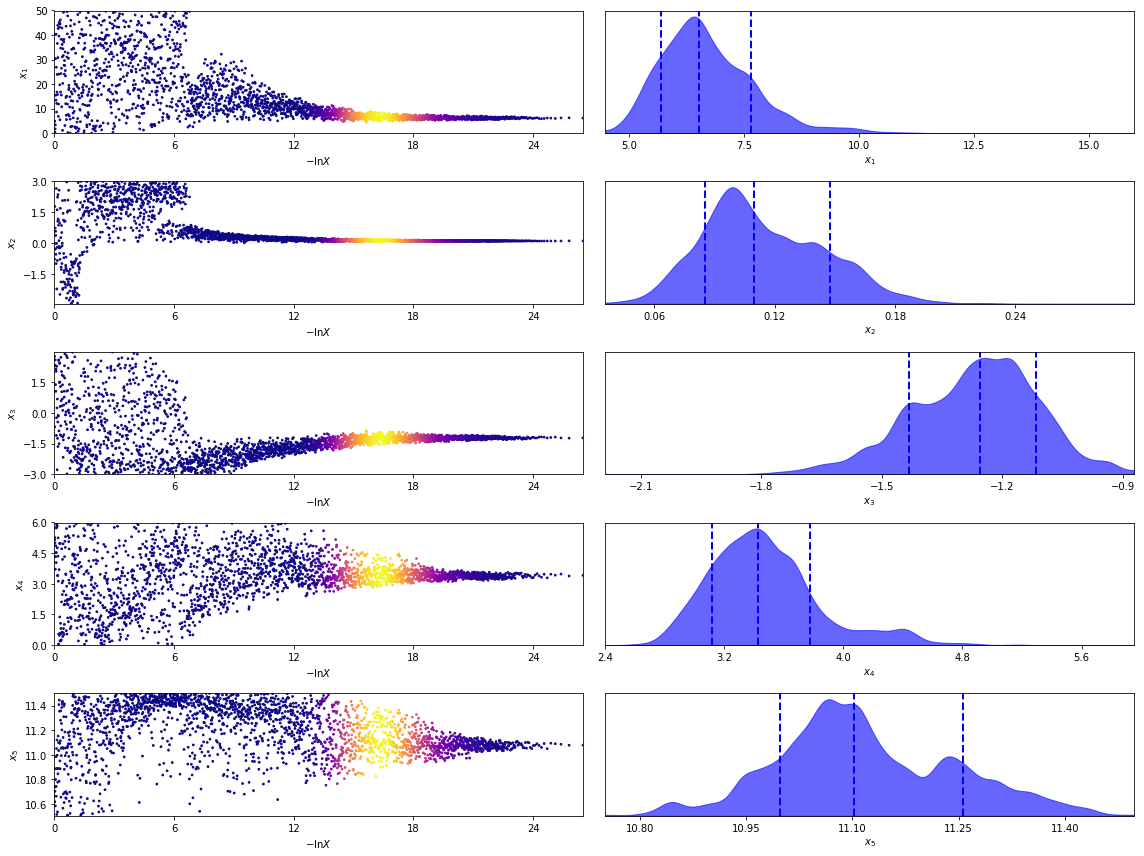

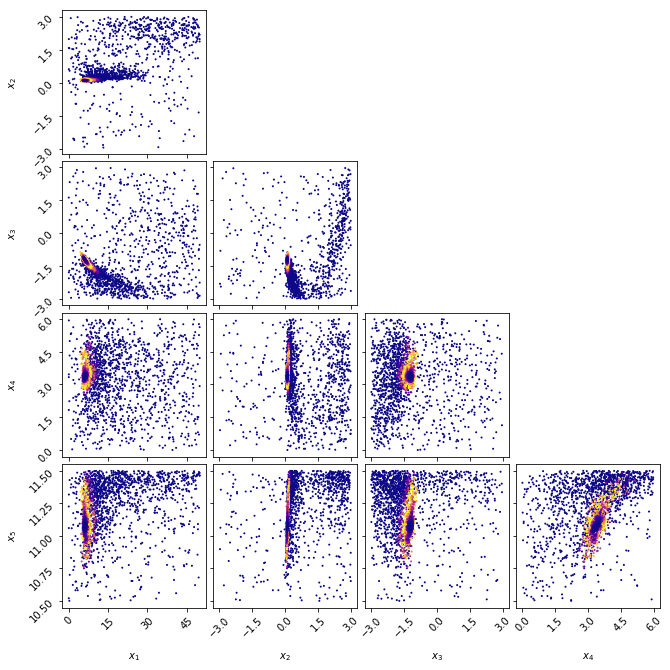

In [20]:
# plot results (i.e. posteriors):
# x1: normalization of SFR profile
# x2: mass-dependence of SFR profile
# x3: redshift-dependence of SFR profile
# x4: power in exponential of merger efficiency
# x5: critical mass scale of merger efficiency

# trace plot
fig, axes = dyplot.traceplot(dres, 
                             fig=plt.subplots(5, 2, figsize=(16, 12)))
fig.tight_layout()
plt.show()

# corner plot
fig, axes = dyplot.cornerpoints(dres)
plt.show()


In [21]:
# compute first moments of posteriors

samples, weights = dres.samples, np.exp(dres.logwt - dres.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

alpha_best, beta_best, gamma_best, delta_best, epsilon_best = mean
print(alpha_best, beta_best, gamma_best, delta_best, epsilon_best)


6.68490802883281 0.11450591168014501 -1.271814494040584 3.4728964521267636 11.117397577620254


In [22]:
samples[:, 0]

array([40.10710676,  4.88541816,  0.39958525, ...,  6.21839077,
        6.27229389,  6.18824357])

In [23]:
weights.shape

(2299,)

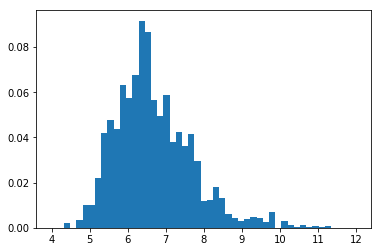

In [24]:
plt.hist(samples[:, 0], bins=np.linspace(4,12), weights = weights)
plt.show()

In [25]:
# plot randomized alpha values
plt.hist(alphaRandom, color = "red")
plt.show()

NameError: name 'alphaRandom' is not defined

In [ ]:
plt.hist(samples[:, 1], bins=np.linspace(0,0.25), weights = weights)
plt.show()

In [ ]:
# plot randomized beta values
plt.hist(betaRandom, color = "red")
plt.show()

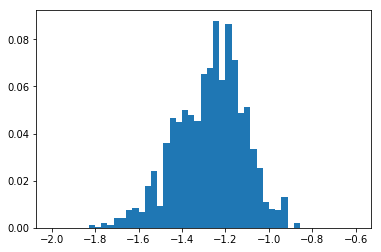

In [26]:
plt.hist(samples[:, 2], bins=np.linspace(-2,-0.6), weights = weights)
plt.show()

In [27]:
# plot randomized gamma values
plt.hist(gammaRandom, color = "red")
plt.show()

NameError: name 'gammaRandom' is not defined

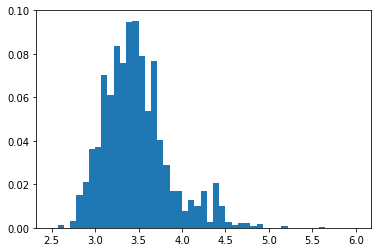

In [28]:
plt.hist(samples[:, 3], bins=np.linspace(2.5,6), weights = weights)
plt.show()

In [29]:
# plot randomized delta values
plt.hist(deltaRandom, color = "red")
plt.show()

NameError: name 'deltaRandom' is not defined

In [30]:
plt.hist(epsilonRandom, bins=np.linspace(10.7,11.5), density=True, histtype='step', color = "red")
plt.hist(samples[:, 4], bins=np.linspace(10.7,11.5), density=True, weights = weights, histtype='step')

plt.show()

NameError: name 'epsilonRandom' is not defined

In [31]:
# plot randomized epsilon values
plt.hist(epsilonRandom, color = "red")
plt.show()

NameError: name 'epsilonRandom' is not defined

In [32]:
alphaRandom = np.random.choice(samples[:, 0], size=1000, replace=True, p=weights)

In [33]:
betaRandom = np.random.choice(samples[:, 1], size=1000, replace=True, p=weights)

In [34]:
gammaRandom = np.random.choice(samples[:, 2], size=1000, replace=True, p=weights)

In [35]:
deltaRandom = np.random.choice(samples[:, 3], size=1000, replace=True, p=weights)

In [36]:
epsilonRandom = np.random.choice(samples[:, 4], size=1000, replace=True, p=weights)

In [37]:
merger_efficiency_samples = samples[:, 4]

2299


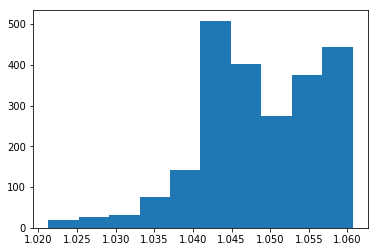

In [38]:
plt.hist(np.log10(merger_efficiency_samples))
print(len(merger_efficiency_samples))
plt.show()

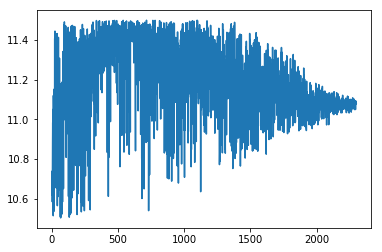

In [39]:
plt.plot(merger_efficiency_samples)
plt.show()

In [40]:
redshift_dependence_samples = samples[:, 2]

2299


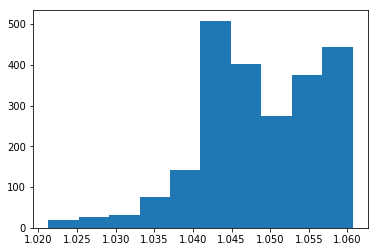

In [41]:
plt.hist(np.log10(merger_efficiency_samples))
print(len(merger_efficiency_samples))
plt.show()

In [42]:
# compute masses and sizes for these galaxies at certain redshifts

redshift_plot = np.array([0.5, 1.0, 1.5, 2.0])

z, mass, RM = get_properties(redshift_plot, alpha_best, beta_best, gamma_best, delta_best, epsilon_best)


/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:98: RuntimeWarning: divide by zero encountered in true_divide
  self.time_boundary = cosmo.age(1.0/self.scale_factor_boundary-1.0).value
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:99: RuntimeWarning: divide by zero encountered in true_divide
  self.time_dt = np.diff(cosmo.age(1.0/self.scale_factor_boundary-1.0).value)


56


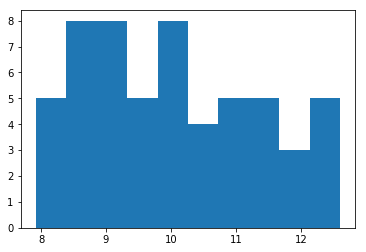

In [43]:
# mass distribution of galaxies (all redshift combined)

plt.hist(np.log10(mass))
print(len(mass))
plt.show()

In [44]:
# prepare plot

log_mass_plot = np.linspace(9.0, 11.8)

def plot_model_and_obs(ax, ii_z):
    idx_s = mass[z==ii_z].argsort()
    ax.plot(np.log10(mass[z==ii_z][idx_s]), np.log10(RM[z==ii_z][idx_s]), '-', color='red', label='Model')
    # plot observations
    ax.plot(log_mass_plot, get_size_observations_all(ii_z, log_mass_plot, 'r50'), '-', lw=4, color='gray', label='Observations')
    # add redshift text
    ax.text(9.15, 1.15, 'z = ' + str(ii_z), fontsize=18)
    # set axes
    ax.set_xlabel(r'$\log\/\/\/\mathrm{M_{\star}}\/\/\/[\mathrm{M_{\odot}}]$', fontsize=18)
    ax.set_ylabel(r'$\log\/\/\/R_{\rm e}\/\/\/[\mathrm{kpc}]$', fontsize=18)
    ax.set_xlim([9.0, 11.5])
    ax.set_ylim([0.2, 1.3])


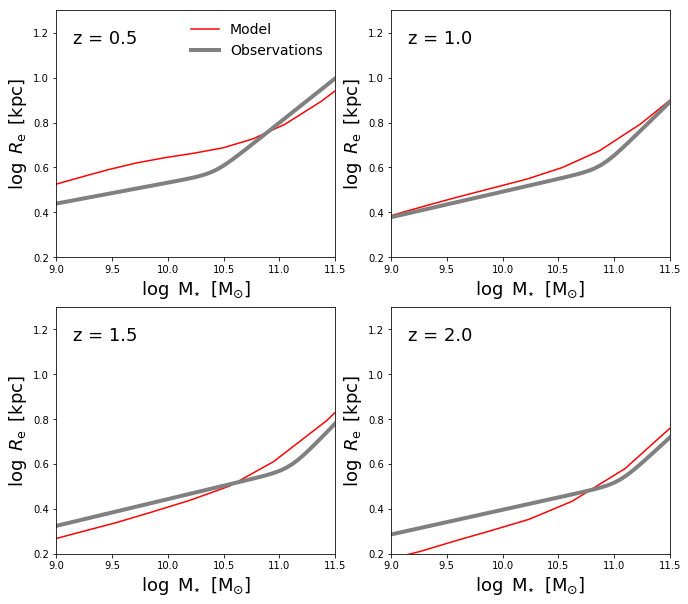

In [45]:
# compare model size-mass relation with observed size-mass relation

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(11, 10))

plot_model_and_obs(ax1, redshift_plot[0])
plot_model_and_obs(ax2, redshift_plot[1])
plot_model_and_obs(ax3, redshift_plot[2])
plot_model_and_obs(ax4, redshift_plot[3])

ax1.legend(frameon=False, fontsize=14, loc=1)

plt.show()


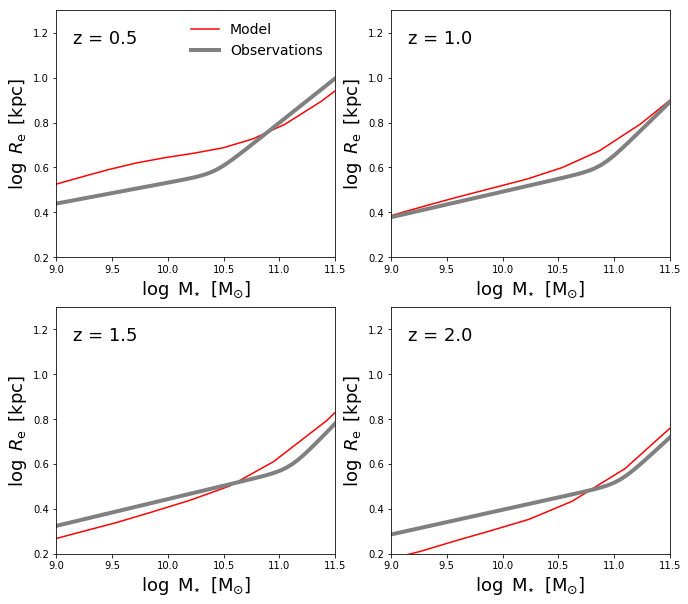

In [46]:
# compare model size-mass relation with observed size-mass relation

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(11, 10))

plot_model_and_obs(ax1, redshift_plot[0])
plot_model_and_obs(ax2, redshift_plot[1])
plot_model_and_obs(ax3, redshift_plot[2])
plot_model_and_obs(ax4, redshift_plot[3])

ax1.legend(frameon=False, fontsize=14, loc=1)

plt.show()


In [47]:
# changed one variable at a time and observed graph differences:


# normalization of SFR profile
# alpha increased to 8, model data above observations
# alpha decreased to 5, model data below observations

# mass-dependence of SFR profile
# beta increased to 1.8, model has steeper slope
# beta decreased to 0.4, model slope is closer to 0

# redshift-dependence of SFR profile
# gamma increased to -0.9, model data above observations
# gamma decreased to -1.8, model data below obersations


# power in exponential of merger efficiency
# delta increased to 5, more of an increase in model graph (smaller slope, then greater slope at higher masses)
# delta decreased to 2.5, model graph appears closer to linear (less change in slope at higher masses)

# critical mass scale of merger efficiency
# epsilon increased to 11.4, slope of model data closer to 0
# epsilon decreased to 10.8, steeper slope of model data

#increased alpha to 8, decreased gamma to 1.4, similar results to best fit values

In [48]:
redshift_plot[0]

0.5

In [49]:
z

array([0.5, 1. , 1.5, 2. , 0.5, 1. , 1.5, 2. , 0.5, 1. , 1.5, 2. , 0.5,
       1. , 1.5, 2. , 0.5, 1. , 1.5, 2. , 0.5, 1. , 1.5, 2. , 0.5, 1. ,
       1.5, 2. , 0.5, 1. , 1.5, 2. , 0.5, 1. , 1.5, 2. , 0.5, 1. , 1.5,
       2. , 0.5, 1. , 1.5, 2. , 0.5, 1. , 1.5, 2. , 0.5, 1. , 1.5, 2. ,
       0.5, 1. , 1.5, 2. ])

In [50]:
# compute masses and sizes for galaxies with randomized alpha, beta, gamma, delta, and epsilon values

redshift_plot = np.array([0.5, 1.0, 1.5, 2.0])

mass_list=[]
RM_list=[]

for ii in np.arange(100):
    print(ii)
    z, mass, RM = get_properties(redshift_plot, alphaRandom[ii], betaRandom[ii], gammaRandom[ii], deltaRandom[ii], epsilonRandom[ii])
    mass_list.append(mass)
    RM_list.append(RM)

0


/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:98: RuntimeWarning: divide by zero encountered in true_divide
  self.time_boundary = cosmo.age(1.0/self.scale_factor_boundary-1.0).value
/home/wolbach/Desktop/SRMP/morph_project/morph_tools/toolbox_morph.py:99: RuntimeWarning: divide by zero encountered in true_divide
  self.time_dt = np.diff(cosmo.age(1.0/self.scale_factor_boundary-1.0).value)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [51]:
mass_list

[array([2.92544797e+09, 1.10034971e+09, 5.22338575e+08, 2.96412712e+08,
        5.89924351e+08, 2.61319513e+08, 1.38917583e+08, 8.30776587e+07,
        1.66786277e+09, 6.55561089e+08, 3.27575660e+08, 1.89675135e+08,
        9.76597956e+08, 4.07231948e+08, 2.10453698e+08, 1.23612061e+08,
        5.29507203e+09, 2.00001810e+09, 8.98402673e+08, 5.00339898e+08,
        3.24296929e+10, 1.68336685e+10, 7.39176105e+09, 3.72075028e+09,
        6.06036080e+10, 3.56873970e+10, 1.61354389e+10, 7.76355758e+09,
        1.77186797e+10, 8.03448701e+09, 3.45914937e+09, 1.79654928e+09,
        1.18093596e+11, 7.78328991e+10, 3.72014745e+10, 1.76033637e+10,
        9.64332458e+09, 3.89808095e+09, 1.67391169e+09, 9.03698736e+08,
        1.36917287e+12, 1.20126354e+12, 8.24613320e+11, 4.41850721e+11,
        3.55979674e+12, 3.23399080e+12, 2.52355174e+12, 1.57564682e+12,
        2.45634410e+11, 1.81038534e+11, 9.30790088e+10, 4.35772439e+10,
        5.60848734e+11, 4.58752069e+11, 2.73532354e+11, 1.322278

In [52]:
# prepare plot for randomized data

log_mass_plot = np.linspace(9.0, 11.8)

def plot_multiple_models_and_obs(ax, ii_z, mass_list, RM_list):
    for jj in np.arange(len(mass_list)):
        mass = mass_list[jj]
        RM = RM_list[jj]
        idx_s = mass[z==ii_z].argsort()
        ax.plot(np.log10(mass[z==ii_z][idx_s]), np.log10(RM[z==ii_z][idx_s]), '-', color='red', alpha=0.3)
    # plot observations
    ax.plot(log_mass_plot, get_size_observations_all(ii_z, log_mass_plot, 'r50'), '-', lw=4, color='gray', label='Observations')
    # add redshift text
    ax.text(9.15, 1.15, 'z = ' + str(ii_z), fontsize=18)
    # set axes
    ax.set_xlabel(r'$\log\/\/\/\mathrm{M_{\star}}\/\/\/[\mathrm{M_{\odot}}]$', fontsize=18)
    ax.set_ylabel(r'$\log\/\/\/R_{\rm e}\/\/\/[\mathrm{kpc}]$', fontsize=18)
    ax.set_xlim([9.0, 11.5])
    ax.set_ylim([0.2, 1.3])

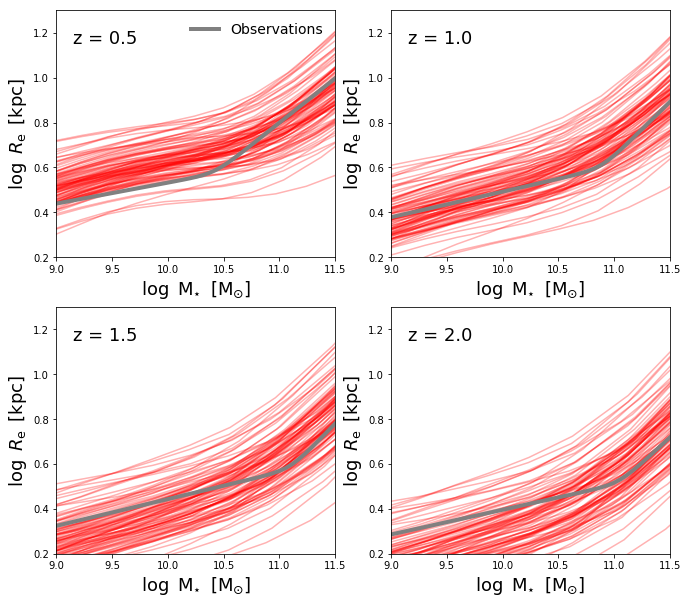

In [53]:
# compare model size-mass relation with observed size-mass relation

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(11, 10))

plot_multiple_models_and_obs(ax1, redshift_plot[0], mass_list, RM_list)
plot_multiple_models_and_obs(ax2, redshift_plot[1], mass_list, RM_list)
plot_multiple_models_and_obs(ax3, redshift_plot[2], mass_list, RM_list)
plot_multiple_models_and_obs(ax4, redshift_plot[3], mass_list, RM_list)

ax1.legend(frameon=False, fontsize=14, loc=1)

plt.show()

In [54]:
(mass_list[0]-mass_list[1])/mass_list[1]

array([3.63833906e-03, 1.07264542e-03, 4.16275330e-04, 2.01411828e-04,
       4.86202276e-04, 1.71276435e-04, 7.57701411e-05, 3.89002200e-05,
       1.80980661e-03, 5.56156593e-04, 2.29013366e-04, 1.13324493e-04,
       9.22470807e-04, 3.02760083e-04, 1.29590684e-04, 6.51408347e-05,
       7.48990299e-03, 2.27076320e-03, 8.29952170e-04, 3.94011085e-04,
       5.33552326e-02, 2.79885435e-02, 1.11248973e-02, 4.88651694e-03,
       8.81563133e-02, 5.80788229e-02, 2.67581102e-02, 1.17818908e-02,
       2.95390362e-02, 1.22622884e-02, 4.46986322e-03, 1.98615329e-03,
       1.30165196e-01, 1.03898740e-01, 6.02062983e-02, 2.93376133e-02,
       1.51357600e-02, 5.17196240e-03, 1.81802842e-03, 8.36156830e-04,
       1.77218235e-01, 1.80411145e-01, 1.86499961e-01, 1.84781765e-01,
       1.41216275e-01, 1.45628272e-01, 1.56336057e-01, 1.73240551e-01,
       1.68260149e-01, 1.54311912e-01, 1.15295959e-01, 6.87082979e-02,
       1.87318333e-01, 1.85341045e-01, 1.72354515e-01, 1.36955962e-01])

In [55]:
def size_distribution(M_interest, z_interest, range):
    RM_at_M_interest = []
    for ii_M in range:
        idx_interest = np.abs(mass_list[ii_M][z==z_interest]-M_interest).argmin()
        size = np.log10(RM_list[ii_M][z==z_interest][idx_interest])
        RM_at_M_interest.append(size)
    return RM_at_M_interest


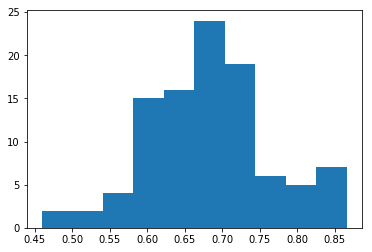

In [56]:
# size distribution at log M. = 10.5
distribution_tenpointfive=size_distribution(10**10.5, 0.5, np.arange(100))
plt.hist(distribution_tenpointfive)
plt.show()


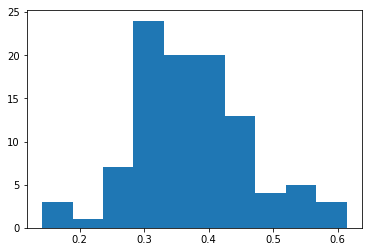

In [57]:
# size distribution at log M. = 9.0
plt.hist(size_distribution(10**9.0, 1.0,np.arange(100)))
plt.show()

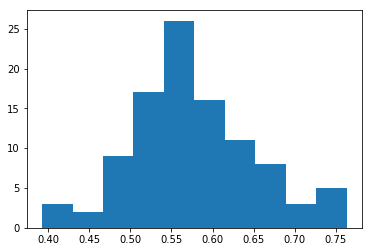

In [58]:
# size distribution at log M. = 9.5
distribution_ninepointfive = size_distribution(10**9.5, 0.5, np.arange(100))
plt.hist(distribution_ninepointfive)
plt.show()

In [59]:
np.percentile(distribution_ninepointfive, 16)

0.5084567899945738

In [60]:
np.percentile(distribution_ninepointfive, 84)

0.6521472858150278

In [61]:
np.percentile(distribution_tenpointfive, 50)

0.6820064951659093

In [62]:
np.mean(distribution_tenpointfive)

0.6816695386800131

# Testing

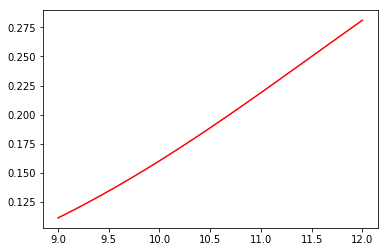

In [63]:
# test sigmoid function

def sigmoid(x, a, b, c):
    return(b/(1.0+np.exp(-a*(x-c))))

x = np.linspace(9.0, 12.0)

plt.plot(x, sigmoid(x, 0.5, 0.5, 11.5), '-', color='red')

plt.show()


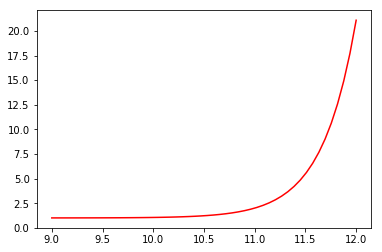

In [64]:
# text exponential function

def exp_fct(x, a, b):
    f = 1.0+np.exp(a*(x-b))
    return(f)

x = np.linspace(9.0, 12.0)

plt.plot(x, exp_fct(x, 3, 11.0), '-', color='red')

plt.show()
